# Analisi Asta Fantacicling UWT 2026

## Scopo dell'Analisi
Questo notebook analizza i risultati dell'asta del Fantacicling per la stagione 2026, confrontando i prezzi pagati dalle squadre con il valore atteso dei corridori.

## Glossario delle Colonne Principali
- **VALORE 2026**: Valore atteso/stimato del corridore per la stagione 2026 (in crediti)
- **Prezzo**: Prezzo effettivamente pagato dalla squadra durante l'asta
- **overpaid**: Sovrapprezzo in valore assoluto, calcolato come `Prezzo - VALORE 2026`. Un valore positivo indica che il corridore è stato pagato più del suo valore atteso
- **overpaid_percentage**: Percentuale del prezzo rispetto al valore atteso, calcolata come `100 * Prezzo / VALORE 2026`. Un valore superiore a 100% indica un sovrapprezzo

In [195]:
import pandas as pd

# Load both Excel files
df_drawn_order = pd.read_excel('Lista-UWT-2026.xlsx')
df_auction_results = pd.read_csv('Lista-UWT-2026_auction_results.csv')

# Add draw_position column (1-based index)
df_drawn_order['draw_position'] = range(1, len(df_drawn_order) + 1)

# Rename VALORE 2026 to valore fanta app
df_drawn_order = df_drawn_order.rename(columns={'VALORE 2026': 'valore fanta app'})

# Create Corridore column by merging NOME + " " + COGNOME
df_drawn_order['Corridore'] = df_drawn_order['NOME'] + ' ' + df_drawn_order['COGNOME']

# Display the dataframes
print("UWT List with draw_position:")
df_drawn_order.head()

UWT List with draw_position:


,Unnamed: 0,COGNOME,NOME,SQUADRA 2025,U25,ITA,valore fanta app,random,draw_position,Corridore
0,NaN,JEANNIERE,Emilien,TOTAL ENERGIES,NaN,NaN,7,0.585853,1,Emilien JEANNIERE
1,NaN,GERMANI,Lorenzo,GROUPAMA FDJ,U,🇮🇹,2,0.497994,2,Lorenzo GERMANI
2,NaN,CARUSO,Damiano,BAHRAIN,NaN,🇮🇹,7,0.621920,3,Damiano CARUSO
3,NaN,LUTSENKO,Alexey,NSN CYCLING TEAM,NaN,NaN,3,0.301747,4,Alexey LUTSENKO
4,NaN,VAN GILS,Maxim,RED BULL BORA,NaN,NaN,16,0.319485,5,Maxim VAN GILS


### Tabella Lista Estrazione (`df_drawn_order`)
Questa tabella contiene la lista dei corridori nell'ordine di estrazione per l'asta.

**Colonne:**
- **COGNOME**, **NOME**: Nome e cognome del corridore
- **SQUADRA 2025**: Squadra professionistica del corridore nella stagione 2025
- **U25**: Indica se il corridore è Under 25 ("U" se sì)
- **ITA**: Bandiera italiana se il corridore è italiano
- **VALORE 2026**: Valore atteso del corridore per la stagione 2026
- **draw_position**: Posizione nell'ordine di estrazione (1 = primo estratto)

In [196]:
df_auction_results.head()

,Corridore,Squadra,Prezzo
0,Emilien JEANNIERE,Samu,1.0
1,Lorenzo GERMANI,NaN,NaN
2,Damiano CARUSO,NaN,NaN
3,Alexey LUTSENKO,NaN,NaN
4,Maxim VAN GILS,Gian,16.0


### Tabella Risultati Asta (`df_auction_results`)
Questa tabella contiene i risultati dell'asta con i corridori acquistati da ciascuna squadra.

**Colonne:**
- **Corridore**: Nome completo del corridore (NOME + COGNOME)
- **Squadra**: Nome della squadra fantasy che ha acquistato il corridore (NaN se non acquistato)
- **Prezzo**: Prezzo pagato all'asta (NaN se non acquistato)

In [197]:
# Left join between df_drawn_order and df_auction_results on Corridore
df_fanta = df_drawn_order.merge(df_auction_results, on='Corridore', how='left')
df_fanta = df_fanta.drop(columns=['NOME', 'COGNOME', 'Unnamed: 0', 'ITA', 'random'])

# Replace Squadra values
df_fanta['Squadra'] = df_fanta['Squadra'].replace({"sambu": "samu",'Sambu': 'Samu', 'Loreng': 'lorengo', "Nele 31": 'Nele', 'Gian': 'lorengo'})
df_fanta['Squadra'] = df_fanta['Squadra'].str.lower()

df_fanta.head()



,SQUADRA 2025,U25,valore fanta app,draw_position,Corridore,Squadra,Prezzo
0,TOTAL ENERGIES,NaN,7,1,Emilien JEANNIERE,samu,1.0
1,GROUPAMA FDJ,U,2,2,Lorenzo GERMANI,NaN,NaN
2,BAHRAIN,NaN,7,3,Damiano CARUSO,NaN,NaN
3,NSN CYCLING TEAM,NaN,3,4,Alexey LUTSENKO,NaN,NaN
4,RED BULL BORA,NaN,16,5,Maxim VAN GILS,lorengo,16.0


In [198]:
pd.unique(df_fanta['Squadra'])

array(['samu', nan, 'lorengo', 'tom n', 'cisco', 'peba', 'nele', 'gino',
       'bicio', 'tom f'], dtype=object)

### Tabella Dati Uniti (`df_fanta`)
Questa è la tabella principale per l'analisi, ottenuta unendo le informazioni dei corridori con i risultati dell'asta.

**Colonne:**
- **SQUADRA 2025**: Squadra professionistica del corridore
- **U25**: Indica se il corridore è Under 25
- **VALORE 2026**: Valore atteso del corridore
- **draw_position**: Posizione nell'ordine di estrazione
- **Corridore**: Nome completo del corridore
- **Squadra**: Squadra fantasy che ha acquistato il corridore
- **Prezzo**: Prezzo pagato all'asta

In [199]:
pd.unique(df_fanta['Squadra'])


array(['samu', nan, 'lorengo', 'tom n', 'cisco', 'peba', 'nele', 'gino',
       'bicio', 'tom f'], dtype=object)

## Analisi del Sovrapprezzo (Overpaid)

In questa sezione calcoliamo e analizziamo quanto ogni squadra ha "strapagato" i corridori rispetto al loro valore atteso.

**Metriche calcolate:**
- **overpaid** = `Prezzo - VALORE 2026`
  - Valore positivo → il corridore è stato pagato più del suo valore atteso
  - Valore negativo → il corridore è stato pagato meno del suo valore atteso (affare!)
  
- **overpaid_percentage** = `100 × Prezzo / VALORE 2026`
  - 100% → prezzo uguale al valore atteso
  - >100% → sovrapprezzo
  - <100% → sottopprezzo

In [200]:
import matplotlib.pyplot as plt

# Add overpaid columns
df_fanta['overpaid'] = df_fanta['Prezzo'] - df_fanta['valore fanta app']
df_fanta['overpaid_percentage'] = 100 * df_fanta['Prezzo'] / df_fanta['valore fanta app']

df_fanta.head()

,SQUADRA 2025,U25,valore fanta app,draw_position,Corridore,Squadra,Prezzo,overpaid,overpaid_percentage
0,TOTAL ENERGIES,NaN,7,1,Emilien JEANNIERE,samu,1.0,-6.0,14.285714
1,GROUPAMA FDJ,U,2,2,Lorenzo GERMANI,NaN,NaN,NaN,NaN
2,BAHRAIN,NaN,7,3,Damiano CARUSO,NaN,NaN,NaN,NaN
3,NSN CYCLING TEAM,NaN,3,4,Alexey LUTSENKO,NaN,NaN,NaN,NaN
4,RED BULL BORA,NaN,16,5,Maxim VAN GILS,lorengo,16.0,0.0,100.000000


## Analisi degli Outliers: Corridori Più Strapagati

In questa sezione identifichiamo i corridori che sono stati pagati significativamente più del loro valore atteso, sia in termini assoluti che percentuali.

Analizziamo due classifiche:
1. **Top 10 per sovrapprezzo assoluto**: I corridori per cui si è pagato di più rispetto al valore atteso (in crediti)
2. **Top 10 per sovrapprezzo percentuale**: I corridori più "strapagati" in proporzione al loro valore (utile per identificare scommesse su corridori di basso valore)

In [201]:
# Top 10 Corridori by Overpaid
top10_overpaid = df_fanta.nlargest(10, 'overpaid')[['Corridore', 'valore fanta app', 'Prezzo', 'overpaid', 'Squadra']]
print("Top 10 Corridori by Overpaid:")
top10_overpaid

Top 10 Corridori by Overpaid:


,Corridore,valore fanta app,Prezzo,overpaid,Squadra
25,Jonas VINGEGAARD,61,220.0,159.0,samu
192,Remco EVENEPOEL,59,201.0,142.0,tom n
16,Mathieu VAN DER POEL,57,171.0,114.0,gino
297,Tadej POGACAR,92,165.0,73.0,peba
53,Isaac DEL TORO,40,110.0,70.0,tom f
176,Giulio PELLIZARI,20,83.0,63.0,samu
95,Thomas PIDCOCK,39,100.0,61.0,cisco
137,Joao ALMEIDA,55,116.0,61.0,cisco
184,Jonathan MILAN,36,95.0,59.0,samu
181,Olav KOOIJ,29,86.0,57.0,lorengo


**Interpretazione Top 10 Overpaid (valore assoluto):**
Questa classifica è dominata dai campioni del ciclismo mondiale (Vingegaard, Evenepoel, Van der Poel, Pogacar). L'alto sovrapprezzo riflette la competizione tra le squadre per assicurarsi i corridori di punta, considerati "imprescindibili" per vincere.

In [202]:
# Top 10 Corridori by Overpaid Percentage
top10_overpaid_pct = df_fanta.nlargest(10, 'overpaid_percentage')[['Corridore', 'valore fanta app', 'Prezzo', 'overpaid_percentage', 'Squadra']]
print("Top 10 Corridori by Overpaid Percentage:")
top10_overpaid_pct

Top 10 Corridori by Overpaid Percentage:


,Corridore,valore fanta app,Prezzo,overpaid_percentage,Squadra
84,Jorgen NORDHAGEN,3,31.0,1033.333333,bicio
305,Ben TULETT,3,25.0,833.333333,bicio
159,Albert WHITEN PHILIPSEN,4,26.0,650.000000,gino
355,Max POOLE,5,26.0,520.000000,tom n
328,Paul SEIXAS,15,69.0,460.000000,nele
195,Tibor DEL GROSSO,7,31.0,442.857143,nele
60,Antonio MORGADO,4,17.0,425.000000,nele
176,Giulio PELLIZARI,20,83.0,415.000000,samu
256,Matthew BRENNAN,14,55.0,392.857143,bicio
102,Jarno WIDAR,4,15.0,375.000000,bicio


**Interpretazione Top 10 Overpaid Percentage:**
Questa classifica evidenzia le "scommesse" delle squadre su giovani promesse o corridori con basso valore atteso. Percentuali superiori al 400-1000% indicano che le squadre hanno investito pesantemente su corridori che ritengono sottovalutati o con alto potenziale di crescita.

---

### Grafico: Valore Atteso vs Prezzo Pagato (Scala Logaritmica)

Il seguente grafico confronta il valore atteso (VALORE 2026) con il prezzo effettivamente pagato all'asta.

**Come interpretare il grafico:**
- **Linea rossa tratteggiata (y=x)**: Rappresenta il "fair value", dove Prezzo = Valore atteso
- **Punti sopra la linea**: Corridori strapagati (Prezzo > Valore)
- **Punti sotto la linea**: Corridori acquistati a sconto (Prezzo < Valore)
- **Scala logaritmica**: Permette di visualizzare meglio sia i corridori di basso valore che quelli di alto valore

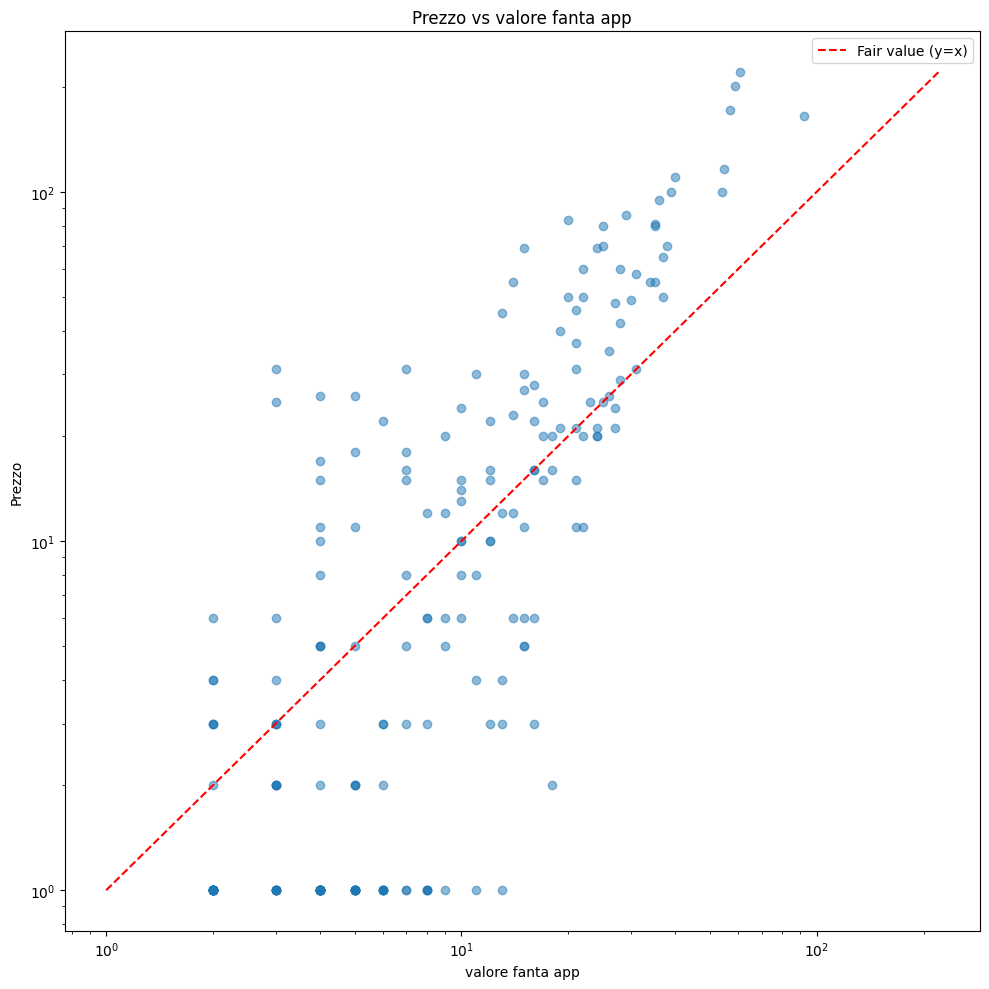

In [203]:
# Graph 3: VALORE 2026 vs Prezzo with diagonal line (log scale)
# Filter out rows with NaN or zero Prezzo for log scale
df_plot = df_fanta[(df_fanta['Prezzo'] > 0) & (df_fanta['valore fanta app'] > 0)].dropna(subset=['Prezzo', 'valore fanta app'])

plt.figure(figsize=(10, 10))
plt.scatter(df_plot['valore fanta app'], df_plot['Prezzo'], alpha=0.5)

# Draw diagonal line (y = x)
max_val = max(df_plot['valore fanta app'].max(), df_plot['Prezzo'].max())
min_val = min(df_plot['valore fanta app'].min(), df_plot['Prezzo'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Fair value (y=x)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('valore fanta app')
plt.ylabel('Prezzo')
plt.title('Prezzo vs valore fanta app')
plt.legend()
plt.tight_layout()
plt.show()

### Grafico: Trend Sovrapprezzo per Fascia di Valore

Il seguente grafico analizza come il sovrapprezzo medio varia in base al valore atteso del corridore.

**Come interpretare il grafico:**
- **Linea blu (asse sinistro)**: Sovrapprezzo medio in valore assoluto per ogni fascia di valore
- **Linea rossa (asse destro)**: Sovrapprezzo medio in percentuale per ogni fascia di valore

Questo grafico aiuta a capire se i corridori di alto valore vengono strapagati di più o di meno rispetto a quelli di basso valore.

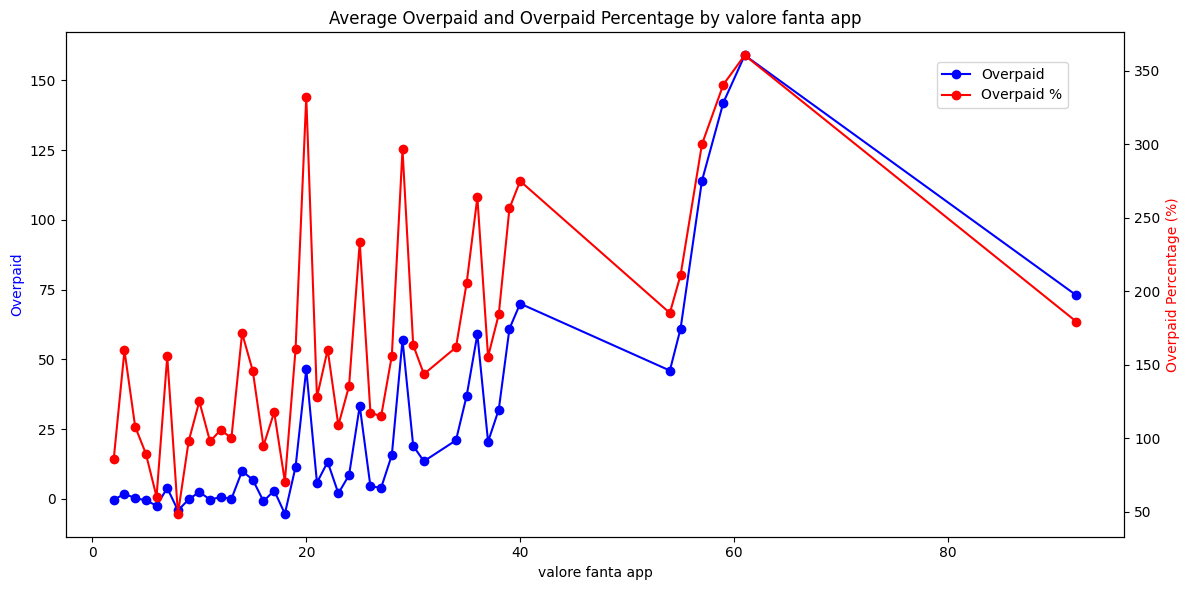

In [204]:
# Graph 4: Line plot - VALORE 2026 vs Overpaid and Overpaid Percentage
avg_by_value = df_fanta.groupby('valore fanta app')[['overpaid', 'overpaid_percentage']].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(avg_by_value.index, avg_by_value['overpaid'], 'b-o', label='Overpaid')
ax1.set_xlabel('valore fanta app')
ax1.set_ylabel('Overpaid', color='blue')

ax2 = ax1.twinx()
ax2.plot(avg_by_value.index, avg_by_value['overpaid_percentage'], 'r-o', label='Overpaid %')
ax2.set_ylabel('Overpaid Percentage (%)', color='red')

plt.title('Average Overpaid and Overpaid Percentage by valore fanta app')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()


## Analisi per Squadra Fantasy

In questa sezione aggreghiamo le statistiche per ogni squadra fantasy per valutare:
- Quanto ogni squadra ha speso in totale
- Quanto valore ha acquisito rispetto alla spesa
- Quali squadre hanno tendenzialmente strapagato di più i propri corridori

**Statistiche calcolate:**
- **sum_overpaid**: Somma totale del sovrapprezzo pagato dalla squadra (in crediti)
- **avg_overpaid_percentage**: Media percentuale del sovrapprezzo sui corridori acquistati
- **sum_valore_2026**: Somma del valore atteso di tutti i corridori acquistati
- **sum_prezzo**: Totale speso all'asta dalla squadra

In [205]:
# Group by Squadra and calculate stats
df_by_squadra = df_fanta.groupby('Squadra').agg({
    'overpaid': 'sum',
    'overpaid_percentage': 'mean',
    'valore fanta app': 'sum',
    'Prezzo': 'sum'
}).rename(columns={
    'overpaid': 'sum_overpaid',
    'overpaid_percentage': 'avg_overpaid_percentage',
    'valore fanta app': 'sum_valore_fanta_app',
    'Prezzo': 'sum_prezzo'
})

df_by_squadra

,sum_overpaid,avg_overpaid_percentage,sum_valore_fanta_app,sum_prezzo
Squadra,,,,
bicio,225.0,190.905850,264,489.0
cisco,152.0,126.838855,323,475.0
gino,198.0,152.537879,281,479.0
lorengo,175.0,134.340868,310,485.0
nele,159.0,126.446142,253,412.0
peba,215.0,173.864374,281,496.0
samu,200.0,64.757572,320,520.0
tom f,128.0,88.413470,356,484.0
tom n,152.0,96.174326,343,495.0


**Interpretazione della Tabella Riepilogo Squadre:**

- **Squadre con alto sum_overpaid**: Hanno pagato molto di più rispetto al valore atteso dei corridori (es. bicio, samu, peba)
- **Squadre con basso/negativo sum_overpaid**: Hanno fatto "affari", pagando meno del valore atteso (es. sambu con -10)
- **avg_overpaid_percentage > 100%**: In media, la squadra ha strapagato i propri corridori
- **Rapporto sum_prezzo/sum_valore_2026**: Indica l'efficienza complessiva della spesa

### Grafici: Posizione di Estrazione vs Sovrapprezzo

I seguenti grafici analizzano se esiste una correlazione tra la posizione di estrazione di un corridore e quanto è stato strapagato.

**Grafico 1: Posizione Estrazione vs Sovrapprezzo (valore assoluto)**
- Mostra se i corridori estratti prima/dopo tendono ad essere più o meno strapagati in termini di crediti

**Grafico 2: Posizione Estrazione vs Sovrapprezzo (percentuale)**
- Mostra la stessa relazione ma in termini percentuali, utile per confrontare corridori con valori diversi

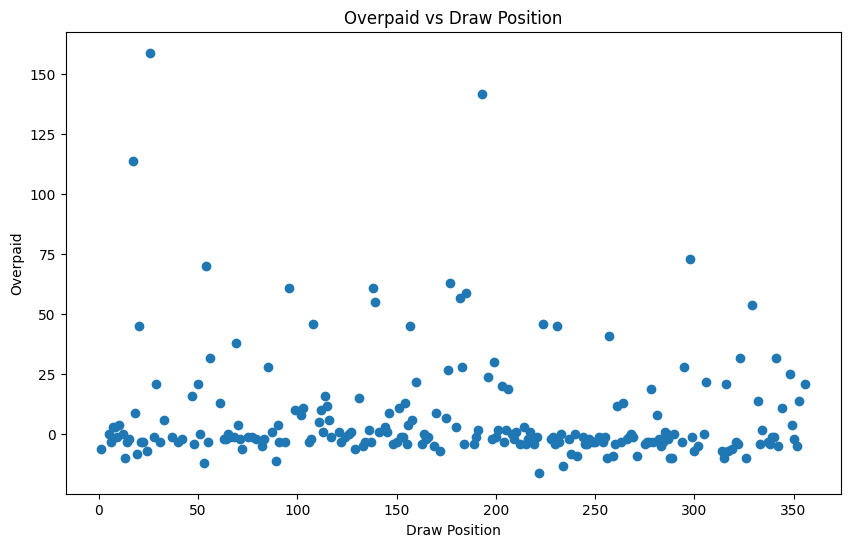

In [206]:
# Graph 1: Draw position vs Overpaid
plt.figure(figsize=(10, 6))
plt.scatter(df_fanta['draw_position'], df_fanta['overpaid'])
plt.xlabel('Draw Position')
plt.ylabel('Overpaid')
plt.title('Overpaid vs Draw Position')
plt.show()

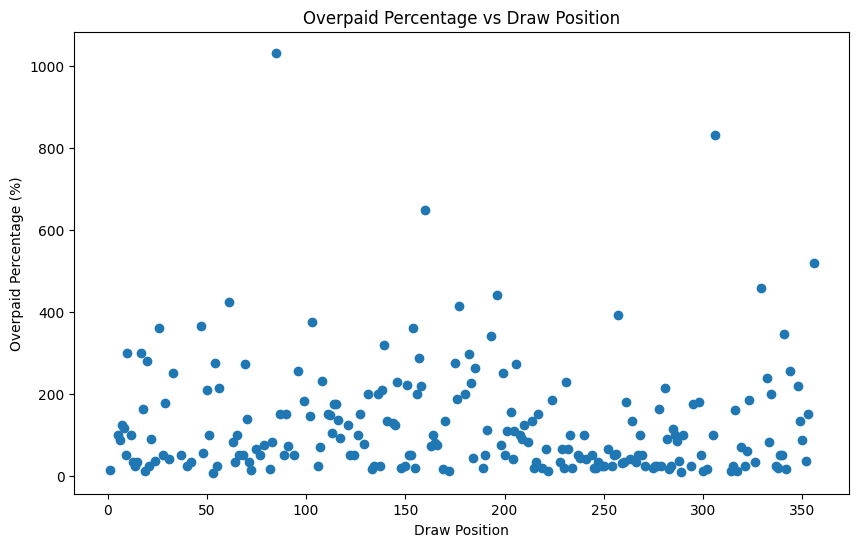

In [207]:
# Graph 2: Draw position vs Overpaid Percentage
plt.figure(figsize=(10, 6))
plt.scatter(df_fanta['draw_position'], df_fanta['overpaid_percentage'])
plt.xlabel('Draw Position')
plt.ylabel('Overpaid Percentage (%)')
plt.title('Overpaid Percentage vs Draw Position')
plt.show()